In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import base
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import re
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot
import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import OrdinalEncoder
sns.set()

In [41]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

<Axes: xlabel='Survived', ylabel='Count'>

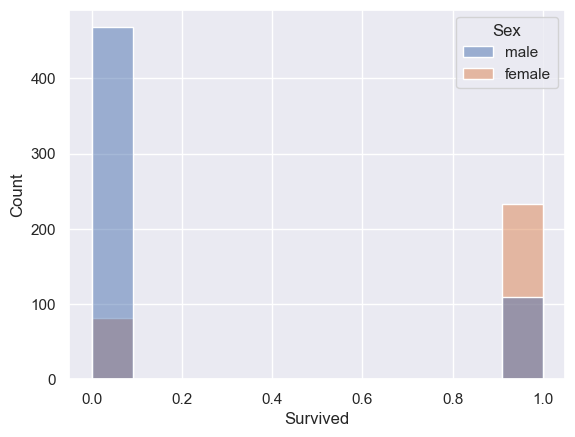

In [42]:
sns.histplot(train, x="Survived", hue="Sex")

In [43]:
y = train.pop('Survived')
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: xlabel='Age', ylabel='Count'>

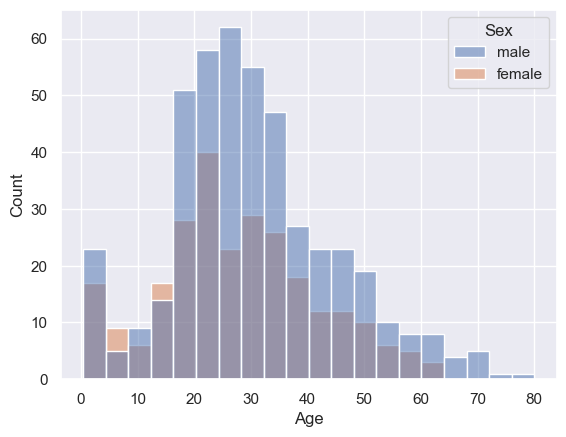

In [44]:
sns.histplot(train, x="Age", hue="Sex")

In [54]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state=42)

In [73]:
class addFeatures(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        cabin = X['Cabin'].fillna('0')
        num_cabins = [len(g.split(' ')) if g != '0' else 0 for g in cabin]
        X['num_cabins'] = num_cabins
        
        child = [1 if a < 13 else 0 for a in X['Age']]
        X['child'] = child
        
        return X

## Tensorflow attempt

In [74]:
add_features = addFeatures()
x_train = add_features.transform(x_train)
x_test = add_features.transform(x_test)

In [75]:
features = ['Fare', 'Age', 'SibSp', 'Parch', 'num_cabins', 'Pclass', 'Sex']
x_train_pre = x_train[features].copy()
x_test_pre = x_test[features].copy()

In [76]:
x_train_pre['Age'] = x_train_pre['Age'].fillna(x_train_pre['Age'].median())
x_test_pre['Age'] = x_test_pre['Age'].fillna(x_test_pre['Age'].median())

In [77]:
enc = OrdinalEncoder()

In [78]:
x_train_pre['Sex'] = enc.fit_transform(x_train['Sex'].values.reshape(-1,1))
x_test_pre['Sex'] = enc.fit_transform(x_test['Sex'].values.reshape(-1,1))
y_train_pre = tf.one_hot(y_train, 2).numpy()
y_test_pre = tf.one_hot(y_test, 2).numpy()

In [79]:
model = keras.models.Sequential()

In [80]:
hidden_size = 2
rate = 0.5
model.add(keras.layers.InputLayer(input_shape=(7,)))
model.add(keras.layers.Dense(hidden_size, activation='sigmoid'))
model.add(keras.layers.Dropout(rate))
model.add(keras.layers.Dense(2, activation='softmax'))

In [81]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.5), metrics=['accuracy'])

In [82]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/keras_example.hdf5',
                                               monitor='val_loss',
                                               verbose=1, save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=.01) 

In [83]:
%%time
history = model.fit(x_train_pre.to_numpy(), y_train_pre,
                    epochs=100,
                    batch_size=30,
                    callbacks=[checkpointer, earlystopping],
                    validation_data=(x_test_pre.to_numpy(), y_test_pre))

Epoch 1/100
 1/23 [>.............................] - ETA: 6s - loss: 0.6992 - accuracy: 0.5333
Epoch 1: val_loss improved from inf to 0.68610, saving model to ./models/keras_example.hdf5
23/23 [==============================] - 0s 8ms/step - loss: 0.6720 - accuracy: 0.6123 - val_loss: 0.6861 - val_accuracy: 0.6009
Epoch 2/100
 1/23 [>.............................] - ETA: 0s - loss: 0.7295 - accuracy: 0.3333
Epoch 2: val_loss did not improve from 0.68610
23/23 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5689 - val_loss: 0.7709 - val_accuracy: 0.6009
Epoch 3/100
 1/23 [>.............................] - ETA: 0s - loss: 0.5984 - accuracy: 0.7667
Epoch 3: val_loss did not improve from 0.68610
23/23 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.6033 - val_loss: 0.7130 - val_accuracy: 0.6009
Epoch 4/100
 1/23 [>.............................] - ETA: 0s - loss: 0.6818 - accuracy: 0.6667
Epoch 4: val_loss did not improve from 0.68610
